<h1 align="center" style="color:blue"> Customer Segmentation </h1>

In [1]:
import pandas as pd

In [131]:
import warnings
warnings.filterwarnings('ignore')

<h2 align="center" style="color:blue">Data Loading</h2>

In [67]:
df = pd.read_csv("MLHW.csv")
df.shape

(1858329, 11)

In [68]:
df.columns

Index(['date', 'product_code', 'market', 'customer_code', 'qty', 'fiscal_year',
       'gross_sales_amt', 'net_sales_amt', 'total_cogs_amt',
       'gross_margin_amt', 'Total_discs'],
      dtype='object')

<h2 align="center" style="color:blue"> Importing and joining with customer table </h2>

In [69]:
cust_df = pd.read_csv("cust_df.csv")
cust_df.shape

(209, 5)

In [70]:
cust_df.columns

Index(['customer', 'market', 'platform', 'channel', 'customer_code'], dtype='object')

In [71]:
df = df.merge(cust_df[['customer_code', 'customer']], on='customer_code',how='left')
df.columns

Index(['date', 'product_code', 'market', 'customer_code', 'qty', 'fiscal_year',
       'gross_sales_amt', 'net_sales_amt', 'total_cogs_amt',
       'gross_margin_amt', 'Total_discs', 'customer'],
      dtype='object')

<h2 align="center" style="color:blue"> Importing and joining with product table </h2>

In [72]:
pro_df = pd.read_csv("pro_df.csv")
pro_df.shape

(397, 6)

In [79]:
pro_df.columns

Index(['product_code', 'division', 'segment', 'category', 'product',
       'variant'],
      dtype='object')

In [81]:
df = df.merge(pro_df[['product_code', 'segment','product']], on='product_code',how='left')
df.columns

Index(['date', 'product_code', 'market', 'customer_code', 'qty', 'fiscal_year',
       'gross_sales_amt', 'net_sales_amt', 'total_cogs_amt',
       'gross_margin_amt', 'Total_discs', 'customer', 'segment', 'product'],
      dtype='object')

In [166]:
df.to_csv("All_merge.csv", index=False)

<h2 align="center" style="color:blue"> Clustering customers for fiscal year 2021 </h2>

In [83]:
df_2021 = df[df['fiscal_year'] == 2021]

In [85]:
# Aggregate to customer-level

import pandas as pd

cust_df = df_2021.groupby('customer_code').agg({
    'net_sales_amt': 'sum',
    'qty': 'sum',
    'Total_discs': 'mean',
    'gross_margin_amt': 'sum',
    'product_code': pd.Series.nunique,
    'market': pd.Series.nunique
}).reset_index()

# Rename columns for clarity
cust_df.rename(columns={
    'net_sales_amt': 'total_sales',
    'qty': 'total_qty',
    'Total_discs': 'avg_discount',
    'gross_margin_amt': 'total_margin',
    'product_code': 'num_products',
    'market': 'num_markets'
}, inplace=True)

# Add derived metrics
cust_df['margin_percent'] = cust_df['total_margin'] / cust_df['total_sales'] * 100

<h2 align="center" style="color:blue"> Scaling</h2>

In [91]:
from sklearn.preprocessing import StandardScaler

features = ['total_sales', 'total_qty', 'avg_discount', 'num_products', 'num_markets', 'margin_percent']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cust_df[features])

<h2 align="center" style="color:blue"> KMeans Clustering Algorithm</h2>

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows wi

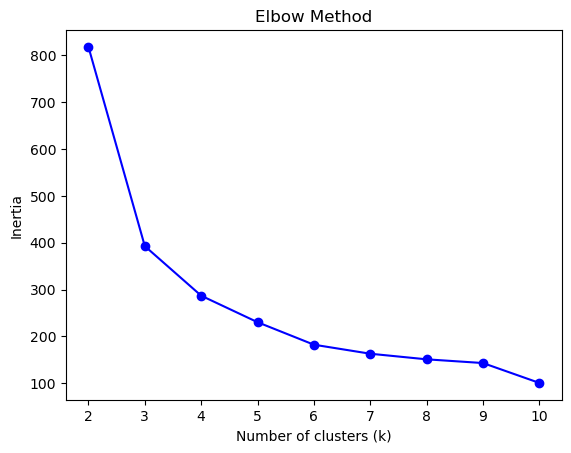

In [93]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

That means the optimal k is 4, because:

At k = 4, you’ve captured most of the variance.

Beyond that, improvements in inertia are smaller (diminishing returns).

<h2 align="center" style="color:blue"> KMeans Clustering Algorithm with optimal number of clusters</h2>

In [95]:
kmeans = KMeans(n_clusters=4, random_state=42)
cust_df['cluster'] = kmeans.fit_predict(X_scaled)

C:\Users\DELL\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


<h2 align="center" style="color:blue">Reverse scaling for interpretability </h2>

Since clustering used standardized data, we need to present metrics in their original business units.

In [100]:
profile_df = cust_df.groupby('cluster').agg({
    'total_sales': 'mean',
    'total_qty': 'mean',
    'avg_discount': 'mean',
    'num_products': 'mean',
    'num_markets': 'mean',
    'margin_percent': 'mean'
}).round(2).reset_index()

In [104]:
profile_df['num_customers'] = cust_df.groupby('cluster')['customer_code'].count().values
print(profile_df['num_customers'])

0    91
1    30
2    38
3    50
Name: num_customers, dtype: int64


<h2 align="center" style="color:blue">Cluster Profiles </h2>

In [106]:
print(profile_df)

   cluster  total_sales  total_qty  avg_discount  num_products  num_markets  \
0        0   2998551.35  166108.15        848.26        333.73          1.0   
1        1    624896.96   36307.80        210.20        320.00          1.0   
2        2  11451103.59  719358.92       4135.57        334.00          1.0   
3        3   1941840.03  132477.34        827.23        333.98          1.0   

   margin_percent  num_customers  
0           42.15             91  
1           38.19             30  
2           34.35             38  
3           29.18             50  


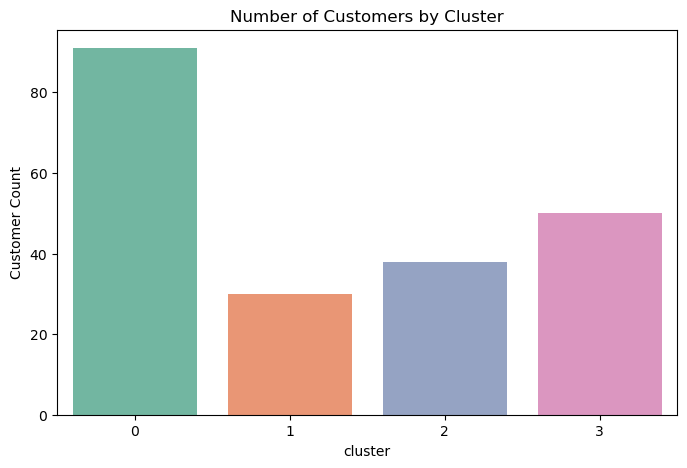

In [153]:
import seaborn as sns

# Bar chart - number of customers per cluster
plt.figure(figsize=(8,5))
sns.countplot(x='cluster', data=cust_df, palette='Set2')
plt.title('Number of Customers by Cluster')
plt.ylabel('Customer Count')
plt.show()

<h2 align="center" style="color:blue">Visualization</h2>

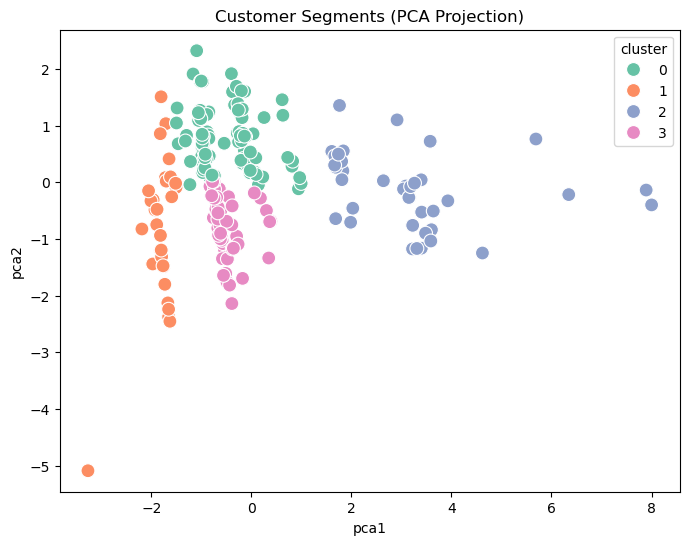

In [151]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

cust_df['pca1'] = pca_result[:,0]
cust_df['pca2'] = pca_result[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=cust_df, x='pca1', y='pca2', hue='cluster', palette='Set2', s=100)
plt.title('Customer Segments (PCA Projection)')
plt.show()

<h2 align="center" style="color:blue">Cluster-level insights </h2>

Cluster 2 → These are your whales — few in number (38 customers) but contribute the largest sales volume. Protect and upsell them.

Cluster 0 → Strong profitability — highest margin % and good revenue. Could be premium or loyal customers.

Cluster 3 → Mid-tier performers. Could be nurtured with targeted offers to move them to Cluster 0 or 2.

Cluster 1 → Small but margin-friendly customers. May be newer accounts or niche buyers.

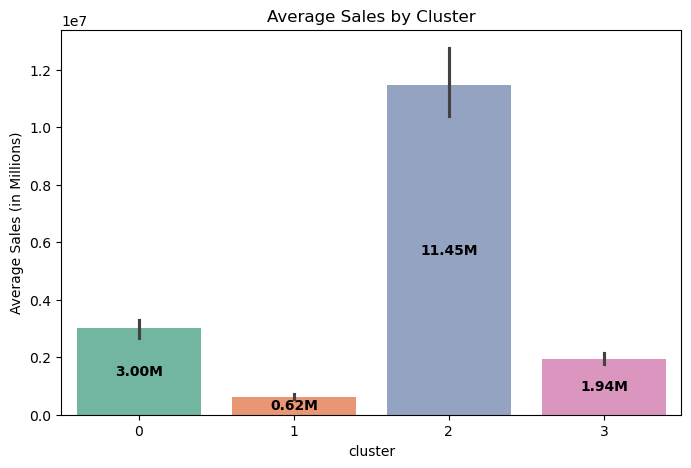

In [155]:
plt.figure(figsize=(8,5))
ax = sns.barplot(
    x='cluster', 
    y='total_sales', 
    data=cust_df, 
    estimator=np.mean,    # Average sales
    palette='Set2'
)

# Add values in millions inside bars
for p in ax.patches:
    value_m = p.get_height() / 1_000_000  # Convert to millions
    label = f"{value_m:.2f}M"
    ax.annotate(label, 
                (p.get_x() + p.get_width() / 2., p.get_height() / 2), 
                ha='center', va='center', 
                color='black', fontsize=10, fontweight='bold')

plt.title('Average Sales by Cluster')
plt.ylabel('Average Sales (in Millions)')
plt.show()

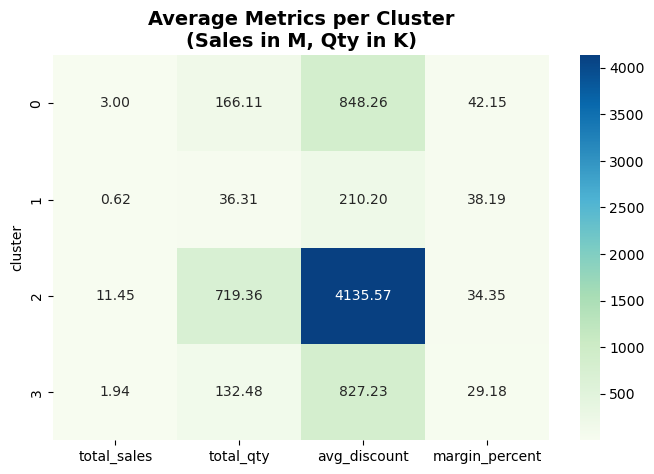

In [164]:
cluster_summary = cust_df.groupby('cluster').agg({
    'total_sales': 'mean',
    'total_qty': 'mean',
    'avg_discount': 'mean',
    'margin_percent': 'mean'
}).round(2)

# Convert for readability
cluster_summary['total_sales'] = (cluster_summary['total_sales'] / 1_000_000).round(2)  # Millions
cluster_summary['total_qty'] = (cluster_summary['total_qty'] / 1_000).round(2)          # Thousands

# Plot heatmap
plt.figure(figsize=(8,5))
sns.heatmap(cluster_summary, annot=True, cmap='GnBu', fmt=".2f")
plt.title('Average Metrics per Cluster\n(Sales in M, Qty in K)', fontsize=14, fontweight='bold')
plt.show()

In [157]:
examples_per_cluster = (
    cust_df.groupby('cluster', group_keys=False)
           .apply(lambda x: x.sort_values(by='total_sales', ascending=False)
                              .head(3)
                              [['customer', 'total_sales']]
                              .assign(total_sales=lambda df: (df['total_sales'] / 1_000_000).round(2),
                                      cluster=x['cluster'].iloc[0]))  # Add cluster column
           .reset_index(drop=True)
)

examples_per_cluster.rename(columns={'total_sales': 'total_sales_millions'}, inplace=True)

print("Top 3 Customers per Cluster (Sales in Millions, with Cluster No.):")
print(examples_per_cluster)

Top 3 Customers per Cluster (Sales in Millions, with Cluster No.):
            customer  total_sales_millions  cluster
0    AltiQ Exclusive                  6.85        0
1    AltiQ Exclusive                  6.50        0
2             Amazon                  6.19        0
3    AltiQ Exclusive                  1.11        1
4    AltiQ Exclusive                  1.10        1
5     Surface Stores                  1.02        1
6               Sage                 22.85        2
7             Leader                 22.38        2
8            Neptune                 20.14        2
9         Digimarket                  3.97        3
10           Amazon                   3.96        3
11  Electricalsocity                  3.94        3


<h2 align="center" style="color:blue">Suggested action plan per cluster </h2>

Cluster 2: Retain aggressively, consider loyalty programs & early product releases.

Cluster 0: Maintain high margins, explore cross-selling without heavy discounts.

Cluster 3: Target for upselling & larger basket sizes.

Cluster 1: Evaluate growth potential — low investment if retention cost is high.

<h2 align="center" style="color:blue">Create separate DataFrames per cluster </h2>

In [114]:
# customer names in cust_df
cust_df = cust_df.merge(df_2021[['customer_code', 'customer']].drop_duplicates(), on='customer_code', how='left')

In [116]:
cluster_0_df = cust_df[cust_df['cluster'] == 0][
    ['customer_code', 'customer', 'total_sales', 'total_qty', 'avg_discount', 'num_products', 'num_markets', 'margin_percent']
].sort_values(by='total_sales', ascending=False)

cluster_1_df = cust_df[cust_df['cluster'] == 1][
    ['customer_code', 'customer', 'total_sales', 'total_qty', 'avg_discount', 'num_products', 'num_markets', 'margin_percent']
].sort_values(by='total_sales', ascending=False)

cluster_2_df = cust_df[cust_df['cluster'] == 2][
    ['customer_code', 'customer', 'total_sales', 'total_qty', 'avg_discount', 'num_products', 'num_markets', 'margin_percent']
].sort_values(by='total_sales', ascending=False)

cluster_3_df = cust_df[cust_df['cluster'] == 3][
    ['customer_code', 'customer', 'total_sales', 'total_qty', 'avg_discount', 'num_products', 'num_markets', 'margin_percent']
].sort_values(by='total_sales', ascending=False)

In [118]:
cluster_0_df.head()

,customer_code,customer,total_sales,total_qty,avg_discount,num_products,num_markets,margin_percent
9,70007198,AltiQ Exclusive,6.852367e+06,345667,1559.106775,334,1,47.203306
2,70003181,AltiQ Exclusive,6.501949e+06,341482,1653.218078,334,1,45.052604
196,90023023,Amazon,6.188930e+06,371184,2104.060008,334,1,36.269941
10,70007199,Atliq e Store,6.055100e+06,358064,1953.288390,334,1,38.605458
64,90003180,Amazon,6.026877e+06,375980,2176.601185,334,1,35.484743
